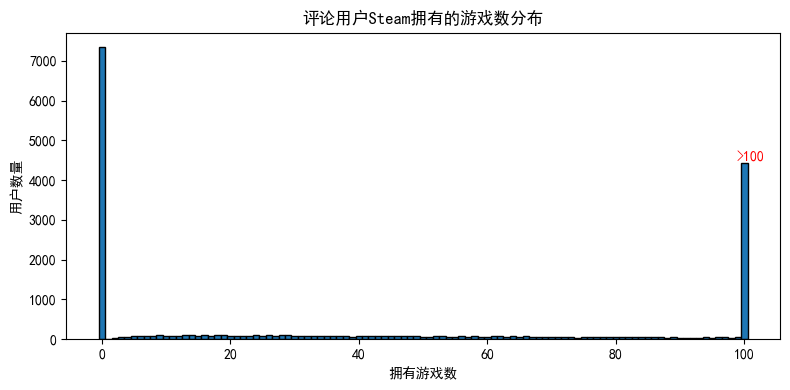

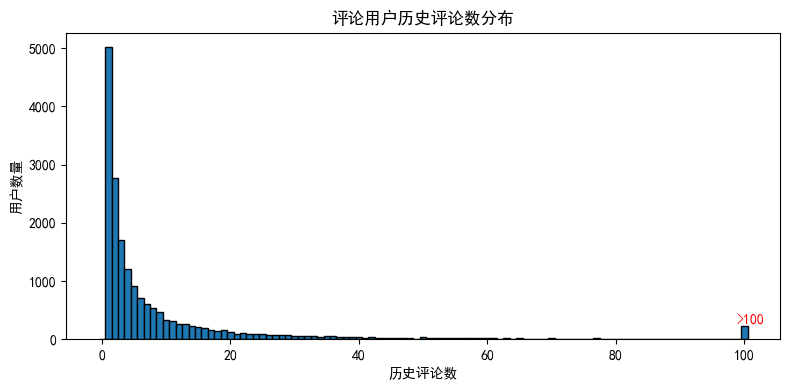

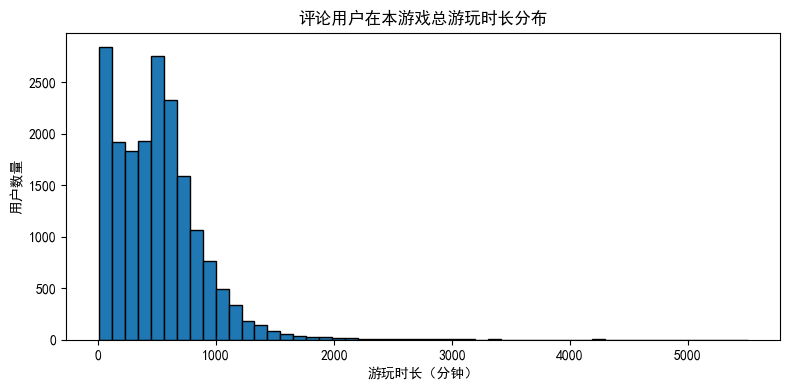

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取数据
df = pd.read_csv('steam_reviews.csv')

# 只保留简体中文评论
df_cn = df[df['language'] == 'schinese']

def plot_hist_with_overflow(series, column_name, bins=20, threshold=100, xlabel='数值', ylabel='用户数量', title=''):
    # 将超过threshold的值都标记为threshold+1（方便分到同一组）
    series = series.fillna(0)
    series_clipped = series.apply(lambda x: x if x <= threshold else threshold+1)
    
    # 画直方图
    plt.figure(figsize=(8, 4))
    counts, bins_, patches = plt.hist(series_clipped, bins=list(range(0, threshold+2)), edgecolor='black', align='left')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    
    # 给最后一根柱子加上“>100”标签
    plt.text(threshold+1, counts[-1], f'>{threshold}', ha='center', va='bottom', fontsize=10, color='red')
    plt.tight_layout()
    plt.show()

# 1. 拥有游戏数分布
plot_hist_with_overflow(df_cn['num_games_owned'], 'num_games_owned',
                        threshold=100, xlabel='拥有游戏数', ylabel='用户数量', title='评论用户Steam拥有的游戏数分布')

# 2. 历史评论数分布
plot_hist_with_overflow(df_cn['num_reviews'], 'num_reviews',
                        threshold=100, xlabel='历史评论数', ylabel='用户数量', title='评论用户历史评论数分布')

# 3. 总游玩时长分布
plt.figure(figsize=(8, 4))
df_cn['playtime_forever'].plot.hist(bins=50, edgecolor='black')
plt.title('评论用户在本游戏总游玩时长分布')
plt.xlabel('游玩时长（分钟）')
plt.ylabel('用户数量')
plt.tight_layout()
plt.show()

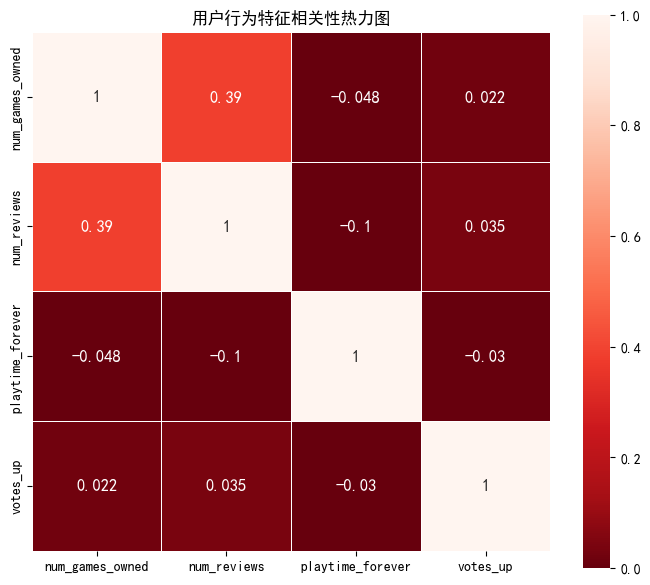

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('steam_reviews.csv')
df_cn = df[df['language'] == 'schinese']

# 只取分析所需的四个变量，去除异常值防止影响结果
cols = ['num_games_owned', 'num_reviews', 'playtime_forever', 'votes_up']
df_corr = df_cn[cols].copy()

# clip异常极端值，提升可读性
for col in cols:
    df_corr[col] = df_corr[col].clip(upper=100)

# 计算相关性矩阵
corr_matrix = df_corr.corr()

# 热力图可视化
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Reds_r', vmin=0, vmax=1, square=True,
            annot_kws={"size": 12}, linewidths=.5)
plt.title('用户行为特征相关性热力图')
plt.tight_layout()
plt.show()


--> 正在加载数据并训练模型...
--> 正在计算 SHAP 值...
--> 正在绘制 SHAP 组合图...


d:\python310\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\python310\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
d:\python310\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\python310\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
d:\python310\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\python310\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x

--> SHAP 组合图已成功保存到文件: shap_analysis_dashboard.png


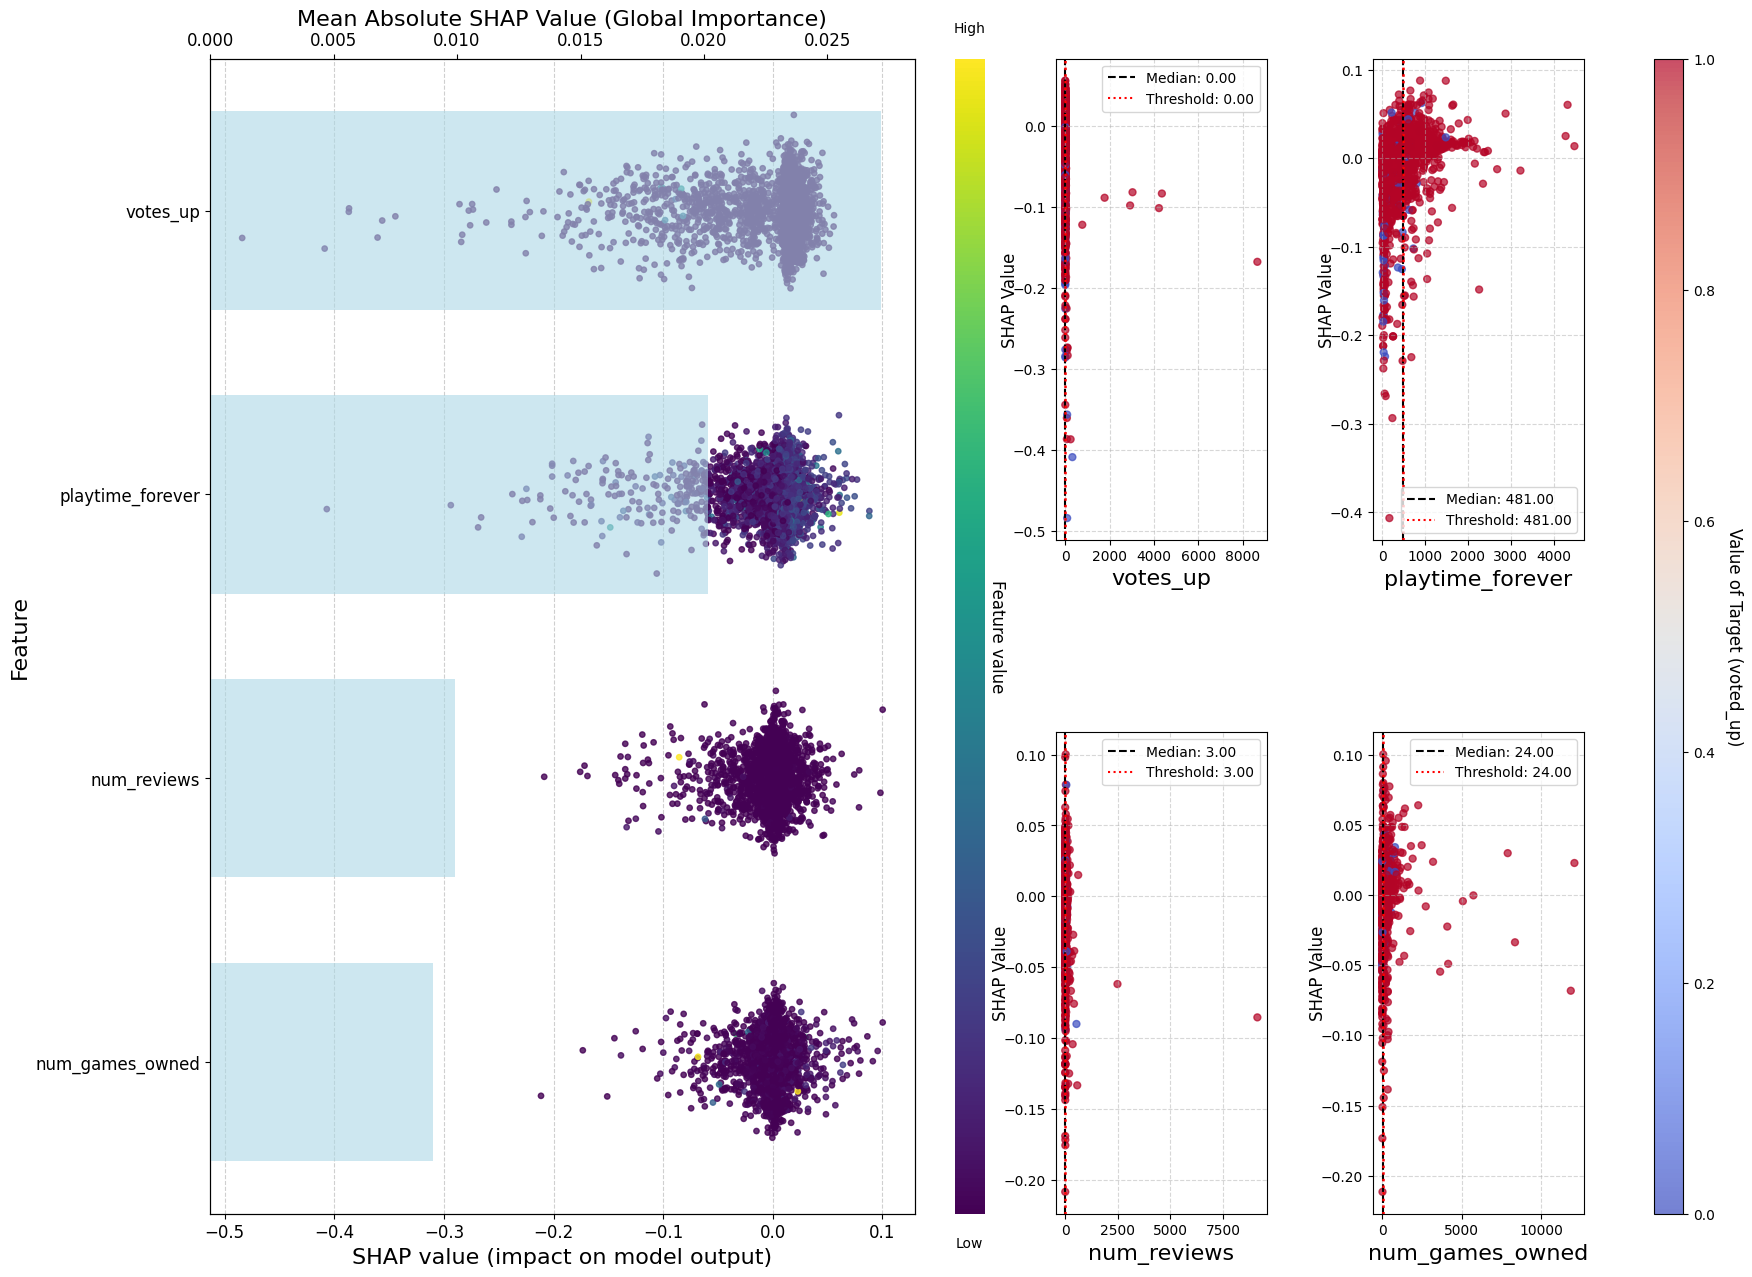

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from kneed import KneeLocator # 导入用于寻找拐点的库

# ==================== 缺失函数定义区 ====================
def find_knee_point(x_data, y_data):
    """
    使用 KneeLocator 寻找曲线的拐点（阈值）.
    这是一个稳健的实现，替代了您代码中缺失的函数.
    """
    # KneeLocator 需要 x 数据是排序好的
    sorted_indices = np.argsort(x_data)
    x_sorted = x_data.iloc[sorted_indices]
    y_sorted = y_data[sorted_indices]
    
    try:
        kneedle = KneeLocator(x_sorted, y_sorted, S=1.0, curve='concave', direction='increasing')
        return kneedle.knee or x_data.median() # 如果找不到拐点，则返回中位数作为备用
    except (ValueError, TypeError):
        # 如果数据无法处理，返回中位数
        return x_data.median()
# ========================================================


# --- 1. 数据准备和模型训练 ---
print("--> 正在加载数据并训练模型...")
# 读取数据
df = pd.read_csv('steam_reviews.csv')
df_cn = df[df['language'] == 'schinese'].copy()

# 特征和目标变量
features = ['num_games_owned', 'num_reviews', 'playtime_forever', 'votes_up']
df_cn = df_cn.dropna(subset=features + ['voted_up'])
X = df_cn[features]
y = df_cn['voted_up'].astype(int)
target_column = 'voted_up' # 定义缺失的变量

# 分训练集/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用分类器并训练
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# --- 2. SHAP 分析 (适配您的代码) ---
print("--> 正在计算 SHAP 值...")
explainer = shap.TreeExplainer(clf)
# 使用 explainer(X_test) 来生成 Explanation 对象, 它包含 .values, .data 等多种属性
# 选择类别 1 (推荐) 的SHAP值进行分析
shap_values = explainer(X_test)[:, :, 1]


# --- 3. 使用您提供的逻辑进行绘图 ---
print("--> 正在绘制 SHAP 组合图...")
# ==================== 美学参数配置区 ====================
aesthetic_params = {
    'suptitle_size': 22, 'ax_label_size': 16, 'tick_label_size': 12,
    'legend_size': 10, 'cbar_label_size': 12,
    'summary_cbar_width': 0.015, 'summary_cbar_height_shrink': 1.0, 'summary_cbar_pad': 0.02,
    'dep_cbar_width': 0.01, 'dep_cbar_height_shrink': 0.6, 'dep_cbar_pad': 0.03,
    'dep_cbar_tick_length': 2, 'grid_wspace': 0.5, 'grid_hspace': 0.4
}
# ========================================================

plt.rcParams['font.family'] = 'sans-serif' # 使用更通用的字体，避免 Times New Roman 缺失错误
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(
    2, 4, figure=fig,
    wspace=aesthetic_params['grid_wspace'],
    hspace=aesthetic_params['grid_hspace']
)

# --- 摘要图 (左侧) ---
ax_main = fig.add_subplot(gs[:, :2])
mean_abs_shaps = np.abs(shap_values.values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shaps
}).sort_values('importance', ascending=True)

ax_main.set_yticks(range(len(feature_importance_df)))
ax_main.set_yticklabels(feature_importance_df['feature'], fontsize=aesthetic_params['tick_label_size'])

ax_top = ax_main.twiny()
ax_top.barh(
    range(len(feature_importance_df)),
    feature_importance_df['importance'],
    color="lightblue", alpha=0.6, height=0.7
)
ax_top.set_xlabel("Mean Absolute SHAP Value (Global Importance)", fontsize=aesthetic_params['ax_label_size'])
ax_top.tick_params(axis='x', labelsize=aesthetic_params['tick_label_size'])
ax_top.grid(False)

cmap = plt.get_cmap("viridis")
for i, feature_name in enumerate(feature_importance_df['feature']):
    original_idx = X_test.columns.get_loc(feature_name)
    shap_vals_for_feature = shap_values.values[:, original_idx]
    feature_vals_for_color = X_test.iloc[:, original_idx].values # 使用 .values 提高性能
    y_jitter = np.random.normal(0, 0.08, shap_vals_for_feature.shape[0])
    ax_main.scatter(
        shap_vals_for_feature, i + y_jitter, c=feature_vals_for_color,
        cmap=cmap, s=15, alpha=0.8, zorder=2
    )

ax_main.set_xlabel("SHAP value (impact on model output)", fontsize=aesthetic_params['ax_label_size'])
ax_main.tick_params(axis='x', labelsize=aesthetic_params['tick_label_size'])
ax_main.grid(True, axis='x', linestyle='--', alpha=0.6)
ax_main.set_ylabel("Feature", fontsize=aesthetic_params['ax_label_size']) # 添加Y轴标签

# --- 摘要图颜色条 ---
fig.canvas.draw()
ax_main_pos = ax_main.get_position()
cax_left = ax_main_pos.x1 + aesthetic_params['summary_cbar_pad']
cax_bottom = ax_main_pos.y0
cax_width = aesthetic_params['summary_cbar_width']
cax_height = ax_main_pos.height
cax = fig.add_axes([cax_left, cax_bottom, cax_width, cax_height])

# 归一化颜色条的值
norm = plt.Normalize(vmin=shap_values.data.min(), vmax=shap_values.data.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Feature value', rotation=270, labelpad=15, fontsize=aesthetic_params['cbar_label_size'])
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', transform=cbar.ax.transAxes, fontsize=aesthetic_params['tick_label_size']-2)
cbar.ax.text(0.5, -0.02, 'Low', ha='center', va='top', transform=cbar.ax.transAxes, fontsize=aesthetic_params['tick_label_size']-2)

# --- 依赖图 (右侧) ---
top_6_features = feature_importance_df['feature'].tail(4).iloc[::-1].tolist()
axes_scatter = []
for i in range(2):
    for j in range(2):
        axes_scatter.append(fig.add_subplot(gs[i, j + 2]))

for i, feature in enumerate(top_6_features):
    ax = axes_scatter[i]
    feature_idx = X_test.columns.get_loc(feature)
    x_data = X_test[feature]
    y_data = shap_values.values[:, feature_idx]
    color_data = y_test # 颜色由目标变量决定

    scatter = ax.scatter(x_data, y_data, c=color_data, cmap='coolwarm', s=25, alpha=0.7)
    
    # 子图的其他元素
    ax.set_xlabel(feature, fontsize=aesthetic_params['ax_label_size'])
    ax.set_ylabel(f"SHAP Value", fontsize=12, labelpad=-5)
    ax.grid(True, linestyle='--', alpha=0.5)

    # 阈值线计算
    median_val = X_test[feature].median()
    threshold_val = find_knee_point(x_data, y_data)

    ax.axvline(median_val, color='black', linestyle='--', linewidth=1.5)
    if threshold_val is not None:
        ax.axvline(threshold_val, color='red', linestyle=':', linewidth=1.8)

    line_handles = [
        Line2D([0], [0], color='black', lw=1.5, linestyle='--', label=f'Median: {median_val:.2f}'),
        Line2D([0], [0], color='red', lw=1.5, linestyle=':', label=f'Threshold: {threshold_val:.2f}')
    ]
    ax.legend(handles=line_handles, loc='best', fontsize=aesthetic_params['legend_size'])
    ax.tick_params(axis='both', which='major', labelsize=aesthetic_params['tick_label_size']-2)

# 添加一个统一的颜色条给所有依赖图
cbar_dep = fig.colorbar(scatter, ax=axes_scatter, orientation='vertical', pad=0.1, aspect=40)
cbar_dep.set_label(f'Value of Target ({target_column})', rotation=270, labelpad=20, fontsize=aesthetic_params['cbar_label_size'])

# --- 最终布局与保存 ---
# fig.suptitle("SHAP Comprehensive Analysis Dashboard", fontsize=aesthetic_params['suptitle_size'], y=0.98)
output_image_path = 'shap_analysis_dashboard.png' # 使用相对路径，更通用
plt.savefig(output_image_path, dpi=600, bbox_inches='tight')
print(f"--> SHAP 组合图已成功保存到文件: {output_image_path}")

plt.show()

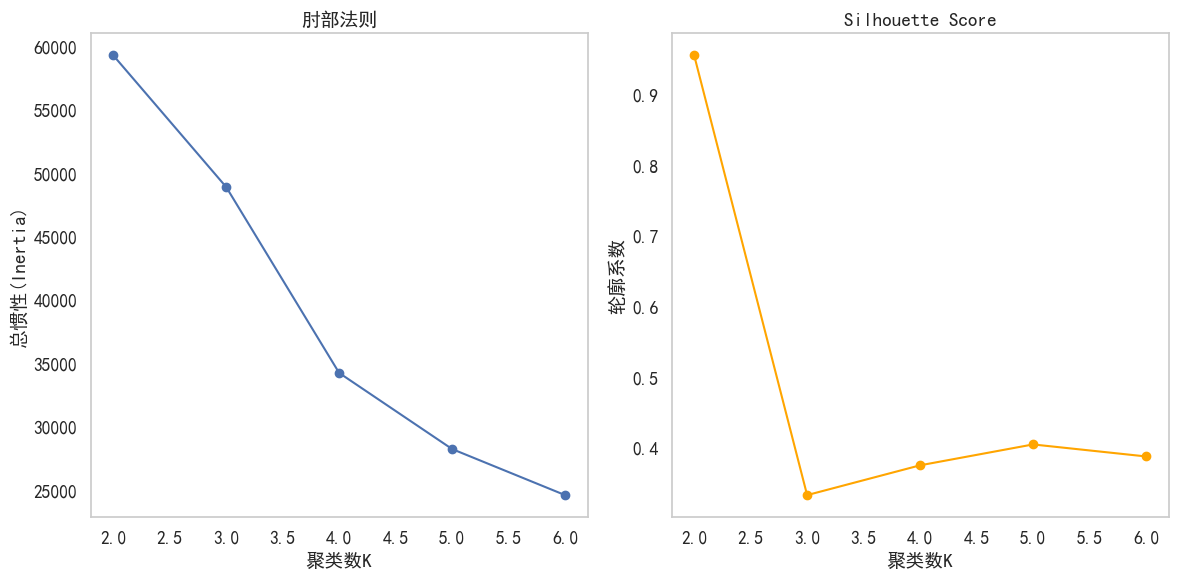

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载数据
df = pd.read_csv('steam_reviews.csv')
df_cn = df[df['language'] == 'schinese'].copy()

# 特征变量
features = ['num_games_owned', 'num_reviews', 'playtime_forever', 'votes_up']
df_cn = df_cn.dropna(subset=features)
X = df_cn[features].copy()

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
df_cn['pca1'] = X_pca[:, 0]
df_cn['pca2'] = X_pca[:, 1]

# 3. 先筛选正常范围数据
df_normal = df_cn[(df_cn['pca1'] <= 10) & (df_cn['pca2'] <= 15)].copy()
X_normal = df_normal[features]
X_normal_scaled = scaler.fit_transform(X_normal)

# 使用肘部法则和轮廓系数选择最佳聚类数
inertias = []
sil_scores = []
K = range(2, 7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_normal_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_normal_scaled, km.labels_))

# 绘制肘部法则和轮廓系数
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.grid(False)
plt.xlabel('聚类数K')
plt.ylabel('总惯性(Inertia)')
plt.title('肘部法则')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.grid(False)
plt.xlabel('聚类数K')
plt.ylabel('轮廓系数')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()


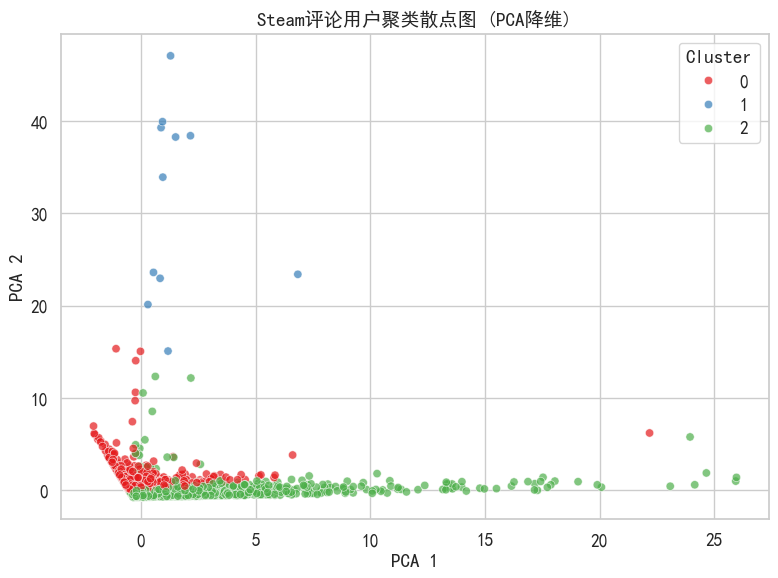

In [29]:
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_normal_scaled)
df_normal['cluster'] = labels

pca_normal = PCA(n_components=2)
X_pca_normal = pca_normal.fit_transform(X_normal_scaled)
df_normal['pca1'] = X_pca_normal[:, 0]
df_normal['pca2'] = X_pca_normal[:, 1]

# 5. 画图
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_normal, x='pca1', y='pca2', hue='cluster', palette='Set1', alpha=0.7)
plt.title('Steam评论用户聚类散点图 (PCA降维)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()